In [3]:
import psycopg2 as pg2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

In [79]:
conn = pg2.connect(user='postgres',  dbname='scrabble', host='localhost', port='5432', password='myPassword')
cur = conn.cursor()


sql = """SELECT game.gamenum, turn_id, movenum, turn_score, rack
from turn inner join game on game.gamenum = turn.gamenum where gamenum in (SELECT gamenum from fullP2games) and NOT is_challenge and
gamenum not in (select game_num from bad_games) and
is_player2 = ' 1' and length(rack) = 7 """

sql +=  """ UNION SELECT gamenum, turn_id, movenum, turn_score, rack
from turn inner join game on game.gamenum = turn.gamenum where gamenum in (SELECT gamenum from fullP1games) and NOT is_challenge and
gamenum not in (select game_num from bad_games) and
is_player2 = ' 0' and length(rack) = 7 ORDER BY movenum"""


df_good_p2 = pd.read_sql(sql ,con=conn)
df_good_p2 = df_good_p2[df_good_p2.rack.apply(len) <= 7]
df_good_p2.rack = df_good_p2.rack.apply(sorted)
df_good_p2.rack

0         [B, D, E, E, O, Q, W]
1         [A, H, L, M, M, R, X]
2         [E, H, K, L, R, T, Z]
3         [D, M, N, O, R, S, V]
4         [A, D, D, E, I, S, Y]
                  ...          
366350    [A, E, G, I, R, R, U]
366351    [I, L, N, N, R, U, V]
366352    [A, B, E, H, I, T, X]
366353    [A, E, E, G, I, R, R]
366354    [?, I, N, S, S, S, U]
Name: rack, Length: 366355, dtype: object

In [178]:
class TileCondition:
    def __init__(self, letter, count, compare):
        self._letter = letter
        self._count = count
        self._compare = compare
    def get_lambda(self):
        if (self._compare=="=="):
            return lambda x: x.count(self._letter)== self._count
        if (self._compare=="<"):
            return lambda x: x.count(self._letter) < self._count
        if (self._compare==">"):
            return lambda x: x.count(self._letter) > self._count
        if (self._compare==">="):
            return lambda x: x.count(self._letter) >= self._count
        if (self._compare=="<="):
            return lambda x: x.count(self._letter) <= self._count
        if (self._compare=="!="):
            return lambda x: x.count(self._letter) != self._count        
        
    def get_label(self):
        if (self._compare=="=="):
            return "Exactly {:} {:}'s".format(self._count, self._letter)
        if (self._compare=="<"):
            return "Less than {:} {:}'s".format(self._count, self._letter)
        if (self._compare==">"):
            return "More than {:} {:}'s".format(self._count, self._letter)
        if (self._compare=="<="):
            return "{:} or less {:}'s".format(self._count, self._letter)
        if (self._compare==">="):
            return "{:} or more {:}'s".format(self._count, self._letter)
        if (self._compare=="!="):
            return "Does not have {:} {:}'s".format(self._count, self._letter)
    
    def get_opposite(self):
        if (self._compare=="=="):
            cond = "!="
        if (self._compare=="<"):
            cond= ">="
        if (self._compare==">"):
            cond="<="
        if (self._compare=="<="):
            cond=">"
        if (self._compare==">="):
            cond= "<"
        if (self._compare=="!="):
            cond = "=="
        return TileCondition(self._letter, self._count, cond)


In [202]:




def evaluate(conditions1, conditions2=None):
    fig, axes = plt.subplots()
    if not conditions2:
        conditions2 = [conditions1[0].get_opposite()]
    #print(conditions2)
    tdf = df_good_p2[df_good_p2.rack.apply(conditions1[0].get_lambda())]
    tdf2 = df_good_p2[df_good_p2.rack.apply(conditions2[0].get_lambda())]
#        print(min(tdf["turn_score"]), max(tdf["turn_score"]))
    if (tdf.shape[0]):
        print("mean score with {:}: {:}, ({:})".format(conditions1[0].get_label(), round(np.mean(tdf["turn_score"]), 2), 
                                                   tdf.shape[0]))
        print("mean score with {:}: {:}, ({:})".format(conditions2[0].get_label(), round(np.mean(tdf2["turn_score"]), 2), 
                                                   tdf2.shape[0]))
#        stat, p = stats.mannwhitneyu(tdf["movenum"], tdf2["movenum"])
#        print('Turn Number p-value: p=%.3f' % ( p))

        print("Score p-value: %.3f" % stats.ttest_ind(tdf.turn_score, tdf2.turn_score).pvalue)
#            print(tdf["gamenum"], print(tdf["rack"]))

#    axes[0].hist(tdf["movenum"], bins=40, density=True, alpha = .5, color='black', label=conditions1[0].get_label())
#    axes[0].hist(tdf2["movenum"], bins=40, density=True, alpha=.5, label=conditions2[0].get_label())
#    axes[0].legend()

    print (np.mean(tdf[""]==1))
    print (np.mean(tdf2["movenum"]==1))
    axes.hist(tdf["turn_score"], bins=100, density=True, alpha = .5, color='black', label=conditions1[0].get_label())
    axes.hist(tdf2["turn_score"], bins=100, density=True, alpha=.5, label=conditions2[0].get_label())
    axes.legend()
    axes.set_xlim(left=0, right=150)
    axes.set_ylim(bottom=0, top =.1)
    print(" ")  


mean score with Less than 1 A's: 32.84, (189691)
mean score with 1 or more A's: 35.5, (176664)
Score p-value: 0.000
0.041035157176671534
0.04321763347371281
 
mean score with Less than 1 B's: 34.37, (323297)
mean score with 1 or more B's: 32.28, (43058)
Score p-value: 0.000
0.0413242312795974
0.047819220586186074
 
mean score with Less than 1 C's: 34.07, (315583)
mean score with 1 or more C's: 34.43, (50772)
Score p-value: 0.001
0.04223294664161251
0.04118411722996927
 
mean score with Less than 1 D's: 33.87, (274667)
mean score with 1 or more D's: 34.87, (91688)
Score p-value: 0.000
0.041435629325692565
0.04404065962830469
 
mean score with Less than 1 E's: 30.77, (131984)
mean score with 1 or more E's: 36.01, (234371)
Score p-value: 0.000
0.04649806037095405
0.0396038759061488
 
mean score with Less than 1 F's: 34.35, (325964)
mean score with 1 or more F's: 32.24, (40391)
Score p-value: 0.000
0.04105054545900774
0.050456784927335296
 
mean score with Less than 1 G's: 34.58, (296477)


/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


mean score with Less than 1 U's: 35.18, (277852)
mean score with 1 or more U's: 30.79, (88503)
Score p-value: 0.000
0.041248578379856904
0.04472164785374507
 
mean score with Less than 1 V's: 34.67, (320349)
mean score with 1 or more V's: 30.33, (46006)
Score p-value: 0.000
0.0416733000571252
0.04497239490501239
 
mean score with Less than 1 W's: 34.49, (326875)
mean score with 1 or more W's: 31.1, (39480)
Score p-value: 0.000
0.04072198852772466
0.05339412360688956
 
mean score with Less than 1 X's: 33.97, (345703)
mean score with 1 or more X's: 36.68, (20652)
Score p-value: 0.000
0.04146622968270452
0.05248886306411001
 
mean score with Less than 1 Y's: 34.25, (329070)
mean score with 1 or more Y's: 32.99, (37285)
Score p-value: 0.000
0.040875801501200355
0.052782620356711815
 
mean score with Less than 1 Z's: 33.84, (345060)
mean score with 1 or more Z's: 38.62, (21295)
Score p-value: 0.000
0.04156958210166348
0.05048133364639587
 
mean score with Less than 1 ?'s: 31.79, (307215)
me

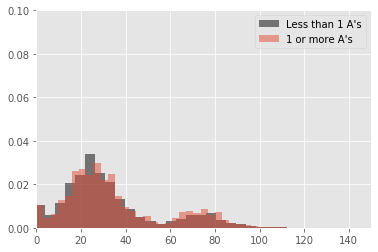

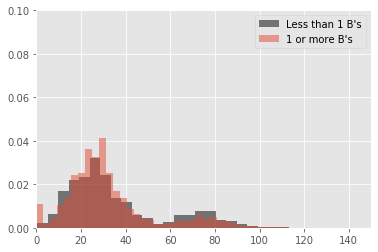

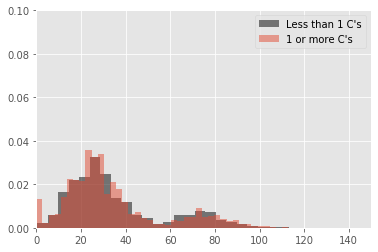

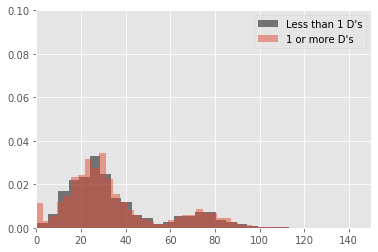

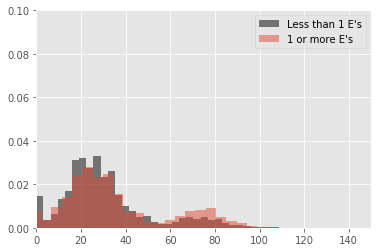

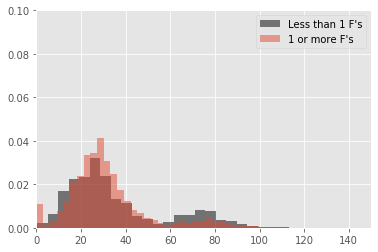

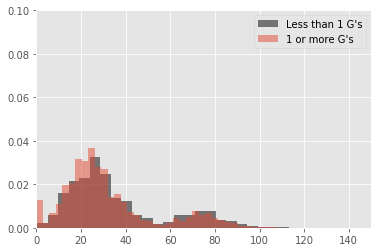

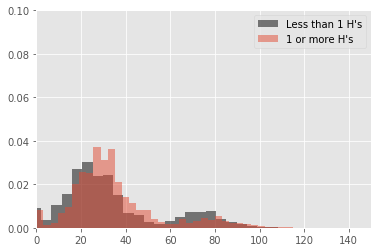

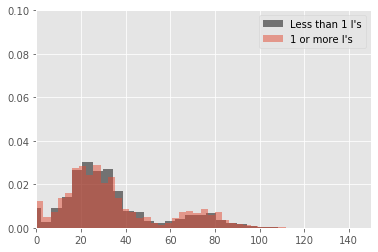

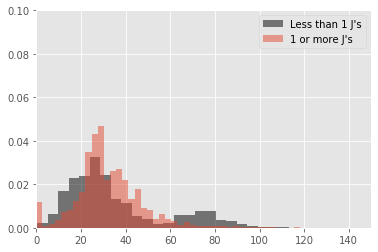

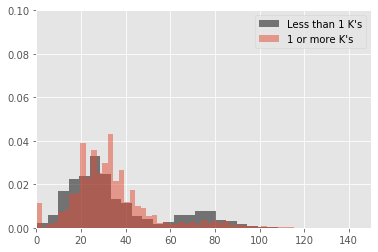

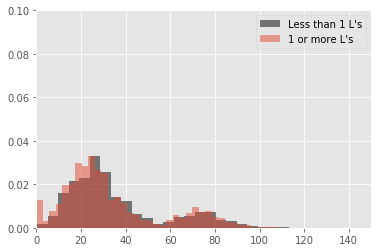

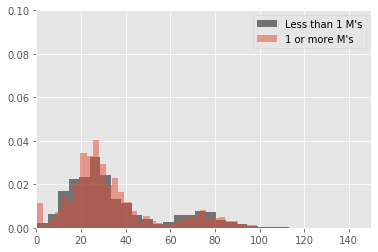

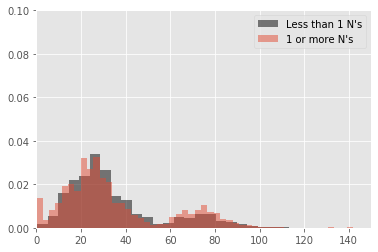

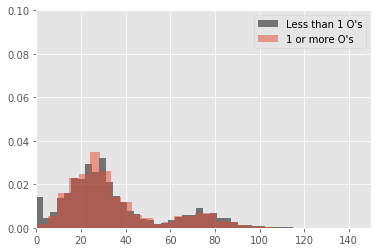

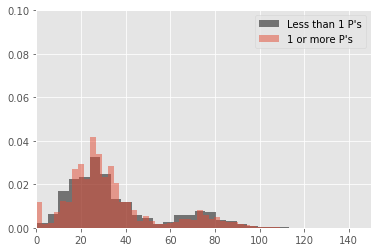

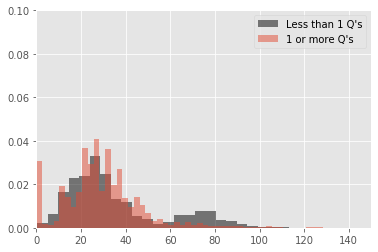

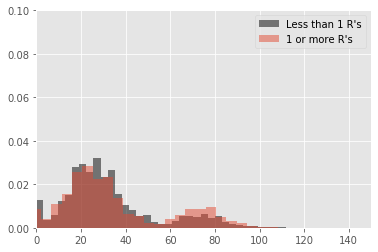

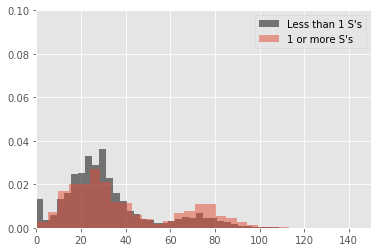

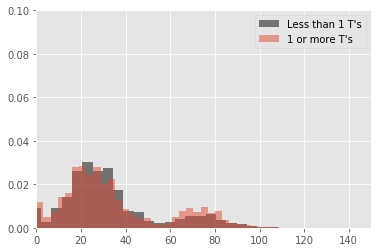

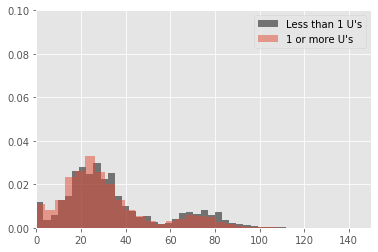

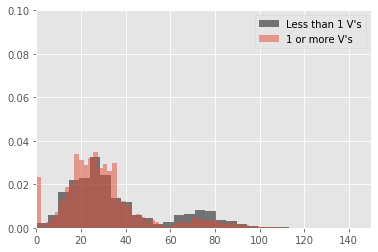

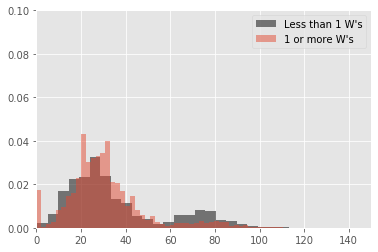

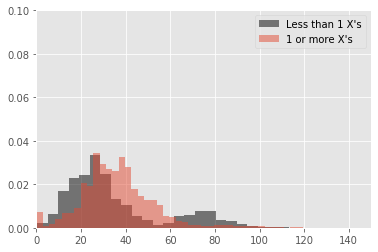

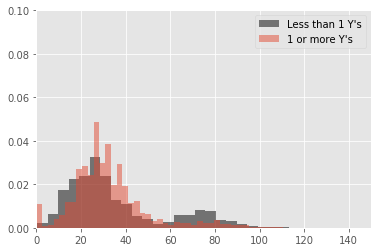

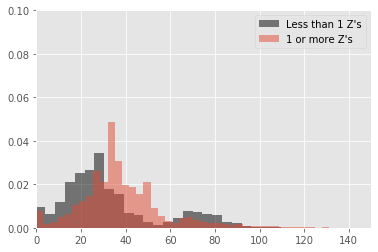

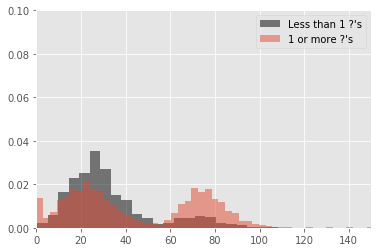

In [201]:
for l in letters:
    evaluate([TileCondition(l, 1, "<")])

In [200]:
## fig, ax = plt.subplots()
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','?']
for l in letters:
    for i in range(0,1):
        print (l)
        tdf = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)<2)]
        tdf2 = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)==2)]
#        print(min(tdf["turn_score"]), max(tdf["turn_score"]))
        if (tdf.shape[0]):
            print("mean score with {:} {:}'s: {:}, ({:})".format(i, l, round(np.mean(tdf["turn_score"]), 2), 
                                                       tdf.shape[0]))
            print("mean score with at least 1 {:}'s: {:}, ({:})".format( l, round(np.mean(tdf2["turn_score"]), 2), 
                                                       tdf2.shape[0])) 
            print("p-value: {:}".format(stats.ttest_ind(tdf.turn_score, tdf2.turn_score).pvalue))
#            print(tdf["gamenum"], print(tdf["rack"]))
        ax.hist(tdf["turn_score"], bins=100, density=True, alpha = .5, color='black')
        ax.hist(tdf2["turn_score"], bins=100, density=True, alpha=.5)
        ax.set_xlim(left=0, right=125)
        print(" ")  
    break;
    print(" ")

A
mean score with 0 A's: 34.63, (329797)
mean score with at least 1 A's: 30.43, (32898)
p-value: 2.0056875971696334e-213
 
